In [1]:
%pylab inline
%matplotlib inline
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import os
import seaborn as sns 
import requests
from bs4 import BeautifulSoup
import folium
import json
import branca.colormap as cm
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


In [2]:
URL = 'http://www.patentsview.org/api/patents/query?'

The API cannot return more than 10000 patents at a time, so we need to get the number of patents for every month and add them together.

In [3]:
def get_nb_patents_month(month, year):
    #patent_date=date patent was granted
    s = ''
    if(month!='12'):
        s = year+'-'+str(int(month)+1) 
    else:
        s = str(int(year)+1)+'-01'
    query = 'q={"_and":[{"_gte":{"patent_date":"'+year+'-'+month+'-01"}},\
        {"_lt":{"patent_date":"'+ s +'-01"}}]}' 
    r = requests.get(URL+query).json()
    return pd.DataFrame(r).total_patent_count[0]

In [4]:
def get_nb_patents_year(year):
    nb_patent=0
    for i in range(12):
        if i<10:
            nb_patent+=get_nb_patents_month('0'+str(i), year)
        else:
            nb_patent+=get_nb_patents_month(str(i), year)
    return nb_patent

In [5]:
years = list(range(2007,2017))
list_nb_patent=[get_nb_patents_year(str(year)) for year in years]
df_nb_patent=pd.DataFrame(index=years)
df_nb_patent['nb_patents']=list_nb_patent
df_nb_patent

,nb_patents
2007,183496
2008,181694
2009,190319
2010,245132
2011,246696
2012,275227
2013,296921
2014,326920
2015,324822
2016,340823


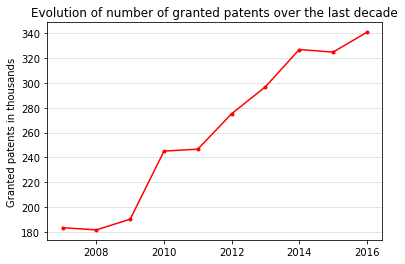

In [6]:
plot(years, df_nb_patent['nb_patents']/1000, 'r', marker= '.')
plt.ylabel('Granted patents in thousands')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
plt.title("Evolution of number of granted patents over the last decade")
plt.show()

In [7]:
dfLocation=pd.read_excel(os.getcwd()+'/location.xlsx').fillna('')

In [8]:
countries=list(set(list(dfLocation['country'])))
#Clean the countries list and keep the Alpha-2 ISO codes only 
countries = [countries[i] for i in range(len(countries)) if (len(countries[i]) == 2 and countries[i]!='a"')]

The function get_nb_patent_country returns the number of granted patents for a given country. There are usually multiple inventors of a patent who can be based in a different country. In that case, count +1 for a country if at least one of the inventor is in the given country. The function give a number of patent between january 2016 and january 2017

***Here we should explain why*** lt":{"patent_date":"2016-07-01**!!!

In [9]:
def get_nb_patent_country(country):
    query='q={"_and":[{"_gte":{"patent_date":"2016-01-01"}},\
    {"_lt":{"patent_date":"2017-01-01"}},{"_eq":{"inventor_country":"'+country+'"}}]}' 
    output='&f=["inventor_country"]'
    option='&o={"matched_subentities_only":True}'
    r = requests.get(URL+query+output).json() 

    try:
        nb_patents= pd.DataFrame(r).total_patent_count[0] 
        
        if nb_patents >= 100000: #Special case (the request cannot give more than 100'000 results)
            query='q={"_and":[{"_gte":{"patent_date":"2016-01-01"}},{"_lt":{"patent_date":"2016-07-01"}},{"_eq":{"inventor_country":"'+country+'"}}]}' 
            r = requests.get(URL+query+output).json() 
            nb_patents= pd.DataFrame(r).total_patent_count[0] 
            query='q={"_and":[{"_gte":{"patent_date":"2016-07-01"}},{"_lt":{"patent_date":"2017-01-01"}},{"_eq":{"inventor_country":"'+country+'"}}]}' 
            r = requests.get(URL+query+output).json() 
            nb_patents += pd.DataFrame(r).total_patent_count[0] 
    except ValueError:
        nb_patents=0
    
    return int(nb_patents)

In [10]:
dfNbPatents=pd.DataFrame(columns=['country','nb_patents'])
dfNbPatents['country']=countries
dfNbPatents['nb_patents']=list(map(lambda x: get_nb_patent_country(x),dfNbPatents['country']))

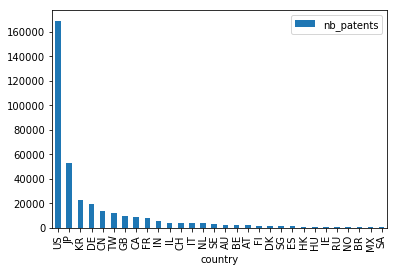

In [11]:
dfNbPatents.sort_values(by='nb_patents',inplace=True, ascending=False)
dfNbPatents.head(30).plot.bar(x='country', y='nb_patents')

In [12]:
dfNbPatents.sort_values(by=['nb_patents'], ascending = False, inplace = True)
dfNbPatents.set_index(pd.Series(list(range(1,len(dfNbPatents) + 1))), inplace=True)
dfNbPatents.head()

,country,nb_patents
1,US,169052
2,JP,53175
3,KR,22593
4,DE,19859
5,CN,14044


In [13]:
dfNbPatents.head()

,country,nb_patents
1,US,169052
2,JP,53175
3,KR,22593
4,DE,19859
5,CN,14044


In [14]:
Keywords_Solar_Power= ["solar cell", "solar-cell","photovoltaic", "solar photo", "PV sun", "light cell",
"panel module"] 
Keywords_Test=["solar cell","photovoltaic"]

In [15]:
def get_patents_keywords(key_words,year):
    
    query_year = '{"_gte":{"patent_date":"'+year+'-01-01"}},{"_lt":{"patent_date":"'+str(int(year)+1)+'-01-01"}}'
  
    nb_patents=0
    dfPatents=pd.DataFrame()
    for i in key_words:         
        query_key_words='{"_text_phrase":{"patent_title":"'+i+'"}}'
        query='q={"_and":['+query_year+','+query_key_words+']}' 
        output='&f=["patent_title","patent_number"]'
        option='&o={"matched_subentities_only":True}' 
        try:
            r = requests.get(URL+query+output).json()
            #print(r)
            nb_patents+=pd.DataFrame(r).total_patent_count[0] 
            dfPatents=pd.concat([dfPatents,pd.DataFrame(r)])
        except ValueError:
            pass   
    return [dfPatents, nb_patents]

In [16]:
[dfPatent, nb_patent]=get_patents_keywords(Keywords_Solar_Power,'2016')
nb_patent

1264

# OA


As there is a very large gap between the number of patents throughout the different countries, we opted for a logarithmic scale for a better vizualisation. Without loss of generality, we shall still be able to vizualize accurate relative differences between numbers.   

In [17]:
max_n = dfNbPatents['nb_patents'] 
colormap = cm.linear.PuBu.scale(0, round(math.log(169052))).to_step(100)
colormap

In [18]:
patents = dfNbPatents.copy()
log_nb = list(map(lambda x: math.log(x) if (x > 0) else 0 , patents['nb_patents']))
log_nb
patents['log_color_code'] = log_nb
patents.head()

,country,nb_patents,log_color_code
1,US,169052,12.037962
2,JP,53175,10.881344
3,KR,22593,10.025395
4,DE,19859,9.896413
5,CN,14044,9.549951


In [19]:
#We need also to convert the table into a dictionnary, in order to map a feature to its number of patents.
patents_dict = patents.set_index('country')['log_color_code']

#Here we map each country to a color according to the "logarithmic" number of patents
color_dict = {key: colormap(patents_dict[key]) for key in patents_dict.keys()}

This functions applies the color to the countries, that were previously stored in **color_dict**.
In case a country does not appear in the list of patents, we assign the white color by default.

In [20]:
#Applies the color to the countries 
def ret_color(feature):
    if (feature['properties']['iso_a2'] in color_dict.keys()):
        return color_dict[feature['properties']['iso_a2']]
    else:
        return '#ffffff'

We can now draw a chloropleth map that shows the number of patents around the world.

In [21]:
m = folium.Map(location= [46.484, 8.1336],tiles='cartodbpositron',zoom_start=2)  

#Load the world map
countries_geo_path = 'custom.geo.json'
geo_json_data = json.load(open(countries_geo_path))

#Apply the colors
folium.GeoJson(geo_json_data,
               style_function=lambda feature: {
              'fillColor': ret_color(feature),
              'weight': .5,
              'fillOpacity': 0.8
               }).add_to(m)

 
colormap = cm.linear.PuBu.scale(0, 170000).to_step(50)
colormap.caption = 'Number of patents'
m.add_child(colormap)

m.save('world.html')

Here is an overview of the world distribution of the number of patents 

![Image](world_patent.png)